## 7-4. 토픽 트렌드로 시간에 따른 주제의 변화 알아내기
토픽 트렌드는 주어진 시간 동안 토픽들의 비중이 어떻게 변화했는지를 봄으로써 주요 토픽의 추이를 분석하는 데 쓰인다. 모든 문서에 생성 날짜가 있다면, 특정한 기간에 만들어진 문서들의 토픽 분포에 대한 평균을 계산해서 그 기간 동안의 토픽 분포를 알아낼 수 있다. 예를 들어 문서들이 만들어진 기간을 월별로 분류하고, 각 월의 토픽 분포 평균을 계산함으로써 매달 토픽이 어떻게 변화했는지를 볼 수 있다.

토픽 트렌드 실습에서는 깃허브에 공개된 "[청와대 국민청원 사이트의 만료된 청원 데이터 모음](https://github.com/akngs/petitions)"을 사용하고자 한다. 깃허브에는 전체 데이터를 담은 petition.csv 외에 결측치가 들어 있는 petition_corrupted.csv와 전체 데이터 중 5%만 임의추출한 petition_sampled.csv 등이 공개돼 있다. 이 실습에서는 속도를 위해 petition_sample.csv를 사용한다.

petition_sampled.csv를 다운로드 후 아래와 같이 판다스로 읽어서 컬럼의 제목과 내용을 확인한다.

In [1]:
import pandas as pd

df = pd.read_csv("../data/petition_sampled.csv")
df.iloc[[2]]

,article_id,start,end,answered,votes,category,title,content
2,136,2017-08-20,2017-11-18,0,4,육아/교육,고등학교 교육 내용 수준을 낮춰주시고 실용적인 내용을 담아주세요!,저는 광주에 사는 중3 학생입니다. 고등학교 가기 직전의 학년이라 어느 때보다 고등...


우선 청원의 내용은 content에 저장돼 있고, 청원의 분류가 category, 그리고 청원 시작날짜와 종료날짜가 각각 start와 end에 저장된 것을 볼 수 있다. 여기서는 분류에 관심이 없으므로 content와 start만을 이용해 토픽 트렌드를 살펴본다. 편의를 위해 사이킷런의 CountVectorizer를 사용하고, 대상이 한국어 문서이므로 CountVectorizer에 한글 형태소 분석기를 붙여준다. 보통 토픽 모델링은 명사를 대상으로 한다. 물론 분석자의 판단에 따라 형용사, 동사 같은 품사를 추가할 수도 있지만, 이 실습에서는 두 자 이상의 명사만 사용하기로 한다.

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from konlpy.tag import Okt # konlpy에서 Twitter 형태소 분석기를 import
twit = Okt()

def tokenizer(doc):
    return [token for token in twit.nouns(doc) if len(token) > 1]

vec = CountVectorizer(tokenizer=tokenizer, # 우선은 명사만 사용
                      max_df=0.5, min_df=5, 
                      max_features=1000) # 적당한 대상 단어 수를 선택

pet_cv = vec.fit_transform(df.content)
print(pet_cv.shape)

(18077, 1000)


생성된 카운트 벡터의 shape을 보면 총 18,077개의 문서에 대해 1,000개의 단어로 구성된 DTM이 생성된 것을 볼 수 있다. 이 결과에 대해 LDA를 수행한다. 앞서 배운 바와 같이 적절한 토픽의 수를 찾기 위해 혼란도를 이용해 모형을 평가할 수 있는데, 그 과정은 생략하고 아래와 같이 저자가 실험을 통해 확인한 15개를 사용하기로 한다. 이번에는 n_jobs와 random_state를 제외한 나머지 매개변수는 기본값을 사용한다. n_jobs는 프로세서(코어) 수에 따라 실행시간에 영향을 많이 미치므로 반드시 지정하는 것이 좋다. 위에서와 같이 print_top_word를 이용해 토픽 별로 상위빈도의 단어를 확인한다.

In [3]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=15,
                                n_jobs=-1,
                                random_state=0)

%time pet_topics = lda.fit_transform(pet_cv)

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d: " % topic_idx, end='')
        print(", ".join([feature_names[i] 
                         for i in topic.argsort()[:-n_top_words - 1:-1]]))
print_top_words(lda,vec.get_feature_names(), 15)

Wall time: 12.2 s
Topic #0: 사람, 생각, 피해자, 처벌, 사건, 병원, 가해자, 대통령, 국민, 나라, 자신, 환자, 정말, 대한민국, 가족
Topic #1: 북한, 한국, 우리, 대통령, 정부, 대한민국, 미국, 국민, 문재인, 일본, 국가, 문제, 생각, 우리나라, 나라
Topic #2: 아이, 부모, 생각, 어린이집, 엄마, 교사, 우리, 유치원, 자녀, 가정, 동물, 가족, 출산, 아빠, 결혼
Topic #3: 청소년, 불법, 보호, 폐지, 장애인, 조직, 이용, 생각, 사찰, 게임, 노인, 사람, 사회, 축구, 나이
Topic #4: 주택, 정부, 정책, 부동산, 서민, 아파트, 국민, 나라, 세금, 대통령, 사람, 지금, 서울, 투기, 집값
Topic #5: 일자리, 정부, 기업, 생각, 근무, 지원, 근로자, 임금, 최저임금, 정책, 시간, 사람, 고용, 대기업, 직원
Topic #6: 국민, 청원, 국회의원, 국회, 난민, 의원, 대통령, 청와대, 정치, 세금, 반대, 생각, 나라, 대한민국, 국가
Topic #7: 관리, 대한, 내용, 판결, 관련, 공사, 조사, 업무, 판사, 확인, 사실, 결과, 기관, 해당, 경우
Topic #8: 학생, 학교, 교육, 선수, 시험, 생각, 대학, 공부, 교사, 선생님, 문제, 시간, 고등학교, 위해, 제도
Topic #9: 보험, 연금, 국민연금, 공무원, 지급, 국민, 방송, 의료, 소득, 건강, 가입, 국가, 보험료, 기초, 제도
Topic #10: 여성, 공무원, 사회, 생각, 남성, 남자, 대한민국, 의무, 사람, 여자, 행정, 군대, 나라, 국가, 문제
Topic #11: 경찰, 범죄, 국민, 사건, 위해, 대한민국, 조직, 불법, 만행, 경찰서, 범죄자, 수사, 부정부패, 검찰, 살인마
Topic #12: 처벌, 차량, 사건, 사고, 경우, 기사, 피해, 대한, 피해자, 안전, 행위, 이명박, 청원, 택시, 관련
Topic #13: 민원, 화폐, 가상, 정부, 투자, 거래

C:\Users\no1hj\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


위 결과를 보면 몇 개의 토픽은 토픽이 비교적 명확해 보이는 반면, 어떤 토픽은 두 개 이상의 토픽이 섞인 것처럼 보이기도 한다. 정확한 토픽을 찾아내기보다는 토픽들의 트렌드를 보는 것이 우리 목표이므로 이 정도로 만족하고 토픽 트렌드를 계산해본다. 토픽 트렌드를 계산하려면 각 문서의 날짜(start)와 토픽 분포를 결합해야 한다. 아래와 같이 먼저 각 토픽에 이름을 주고, 원본으로부터 날짜를 가져와서 trend_data라는 이름으로 데이터프레임을 생성한다. 다만 청원 데이터가 수집된 기간이 꽤 길어서 일별로 보는 것은 무리가 있으므로 날짜에서 연도와 월만 잘라서 가져온다.

In [4]:
trend_data = pd.DataFrame(pet_topics, columns=['Topic'+str(i) for i in range(1, 16)])
trend_data = pd.concat([trend_data, df.start.map(lambda x: x[:7])], axis=1)
trend_data.iloc[:5, -5:]

,Topic12,Topic13,Topic14,Topic15,start
0,0.000307,0.000307,0.000307,0.000307,2017-08
1,0.000813,0.000813,0.000813,0.551813,2017-08
2,0.001449,0.001449,0.001449,0.001449,2017-08
3,0.000227,0.000227,0.000227,0.041175,2017-08
4,0.000447,0.000447,0.000447,0.000447,2017-08


생성된 trend_data의 뒷부분 열을 확인해보면 날짜가 잘 결합된 것을 볼 수 있다. 이제 pandas의 groupby를 이용해 월별로 평균을 구하고, 데이터를 확인해본다.

In [5]:
trend = trend_data.groupby(['start']).mean()
trend.iloc[:5, -5:]

,Topic11,Topic12,Topic13,Topic14,Topic15
start,,,,,
2017-08,0.031564,0.015125,0.032138,0.026306,0.107615
2017-09,0.041628,0.025142,0.053777,0.020606,0.039820
2017-10,0.084683,0.053623,0.057386,0.031646,0.088069
2017-11,0.045303,0.040608,0.229142,0.040015,0.048151
2017-12,0.055756,0.026878,0.071888,0.048763,0.081157


연도별 토픽별 평균값이 잘 계산된 것을 볼 수 있다. 이제 남은 것은 matplotlib을 이용해 각 토픽에 대해 그래프를 그려보는 것이다. 아래와 같이 5*3으로 분할해 그래프를 그린다.

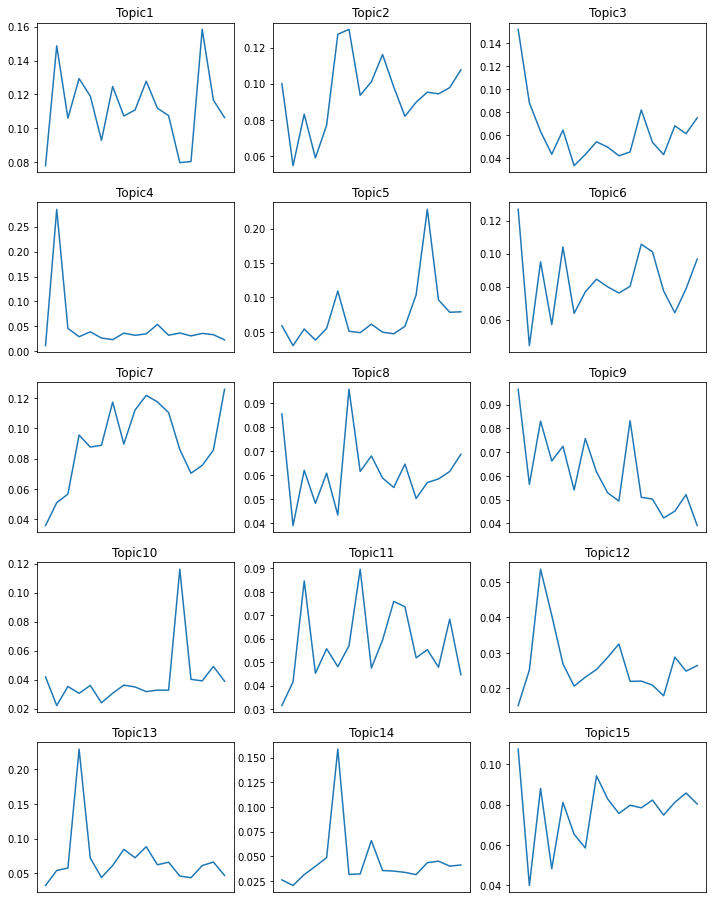

In [6]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(5, 3, sharex='col', figsize=(12, 16)) 
for col, ax in zip(trend.columns.tolist(), axes.ravel()): 
    ax.set_title(col)
    ax.axes.xaxis.set_visible(False)
    ax.plot(trend[col])
plt.show()

위 결과를 보면 어떤 토픽들은 트렌드가 잘 나타난다. 예를 들어 Topic3, 4, 9, 13은 초기에 비중이 높았다가 뒤로 가면서 점차 줄어드는 경향이 있다. 이와 같은 토픽들을 Cold Topic이라고 한다. 반면, Topic 5, 13은 뒤로 가면서 비중이 더 높아지는 경향이 있는데 이런 유형을 Hot Topic이라고 부른다. 이러한 토픽 트렌드 분석은 사람들의 관심이 점차 사라져가는 주제와 높아지는 주제를 찾아낼 수 있어, 다양한 분야에서 연구주제의 변화, 사람들의 관심의 변화 등을 알아내는 데 활용된다.